Using device: cuda
Loading model...
Model loaded successfully!

=== Facial Expression Recognition ===
Please upload an image to detect the facial expression.


Saving profile.jpg to profile.jpg
Processing image: profile.jpg


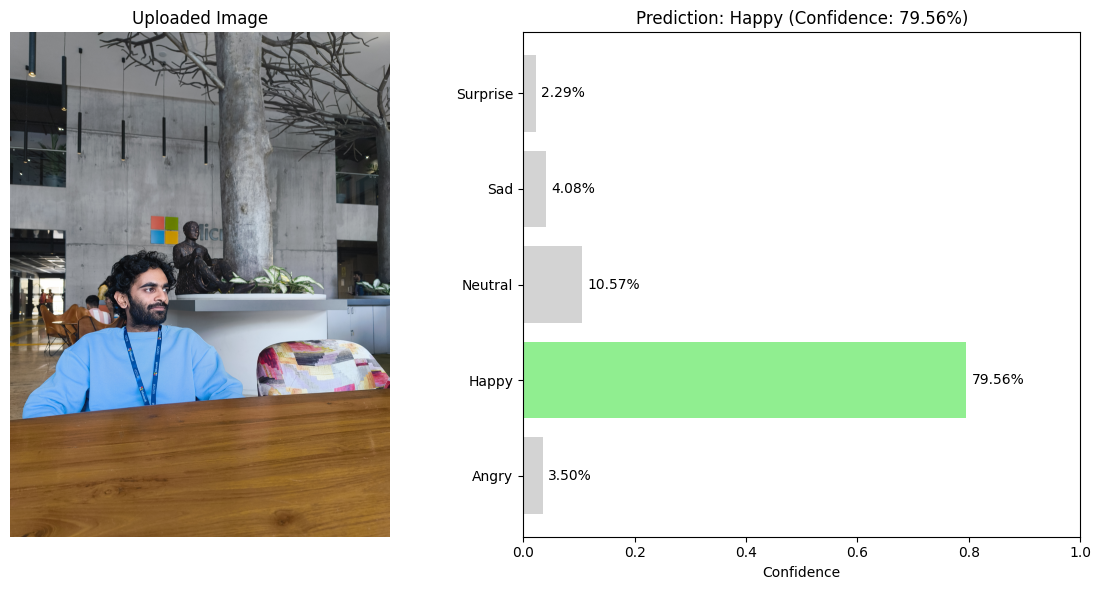


Prediction: Happy
Confidence: 79.56%

Confidence for each expression:
  Angry: 3.50%
  Happy: 79.56%
  Neutral: 10.57%
  Sad: 4.08%
  Surprise: 2.29%


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import io
from google.colab import files
from IPython.display import display, HTML

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define model architecture (must match the training architecture)
class ExpressionRecognitionModel(nn.Module):
    def __init__(self, num_classes=5):
        super(ExpressionRecognitionModel, self).__init__()
        # Load pre-trained ResNet50
        self.backbone = models.resnet50(weights=None)  # No need for pretrained weights when loading model

        # Replace the final fully connected layer
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # Custom classifier with dropout and batch normalization
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Extract features from the backbone
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)  # [batch_size, 2048, 7, 7]

        # Apply attention mechanism
        attention_weights = self.attention(x)
        x = x * attention_weights

        # Global average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)

        # Apply classifier
        x = self.classifier(x)
        return x

# Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define class names
class_names = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Function to load the model
def load_model(model_path):
    model = ExpressionRecognitionModel(num_classes=5).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Function to make prediction
def predict(model, image):
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)[0]
        confidence, prediction = torch.max(probabilities, 0)

    return {
        'class': class_names[prediction.item()],
        'confidence': confidence.item(),
        'probabilities': {class_names[i]: prob.item() for i, prob in enumerate(probabilities)}
    }

# Function to display result
def display_result(image, result):
    plt.figure(figsize=(12, 6))

    # Display image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Uploaded Image")
    plt.axis('off')

    # Display prediction and confidence
    plt.subplot(1, 2, 2)

    # Create bar chart for probabilities
    classes = list(result['probabilities'].keys())
    values = list(result['probabilities'].values())

    colors = ['lightgray'] * len(classes)
    colors[classes.index(result['class'])] = 'lightgreen'

    bars = plt.barh(classes, values, color=colors)
    plt.xlim(0, 1.0)
    plt.title(f"Prediction: {result['class']} (Confidence: {result['confidence']:.2%})")
    plt.xlabel('Confidence')

    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2%}',
                 ha='left', va='center')

    plt.tight_layout()
    plt.show()

# Main function
def main():
    print("Loading model...")
    try:
        model = load_model("/content/final_model.pth")
        print("Model loaded successfully!")
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        print("Make sure the model file is at /content/final_model.pth")
        return

    print("\n=== Facial Expression Recognition ===")
    print("Please upload an image to detect the facial expression.")

    # Upload image
    uploaded = files.upload()

    for filename in uploaded.keys():
        # Load image
        image = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')

        # Make prediction
        print(f"Processing image: {filename}")
        result = predict(model, image)

        # Display result
        display_result(image, result)

        print(f"\nPrediction: {result['class']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print("\nConfidence for each expression:")
        for cls, prob in result['probabilities'].items():
            print(f"  {cls}: {prob:.2%}")

# Run the application
if __name__ == "__main__":
    main()